In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def beam_height(range_max, elev_angle_deg, antenna_height_km,
                num_points=100, k=4/3, earth_radius_km=6378.1370):
    """
    Compute the radar beam’s height above ground as a function of slant range,
    accounting for Earth’s curvature and standard atmospheric refraction.

    Parameters
    ----------
    range_max : float
        Maximum slant range distance (in km) over which heights are computed.
    elevation_angle_deg : float
        Elevation angle of the radar beam (in degrees).
    antenna_height_km : float
        Height of the radar antenna above ground level (in km).
    num_points : int, optional
        Number of discrete range points between 0 and range_max to calculate
        (default is 100, matching the original MATLAB).
    k : float, optional
        Effective Earth‐radius scaling factor due to refraction (default is 4/3).
    earth_radius_km : float, optional
        Mean radius of the Earth (in km; default is 6378.1370).

    Returns
    -------
    numpy.ndarray
        1D array of length `num_points` giving the beam’s height (in km)
        at evenly spaced slant ranges from 0 to `range_max`.

    Notes
    -----
    Uses the “4/3 Earth‐radius” approximation:
        h(r) = √[ r² + (k·Re)² + 2·r·(k·Re)·sin(θ) ] − (k·Re) + antenna_height
    where r is slant range and θ is elevation angle in radians.
    """
    elev_rad = np.deg2rad(elev_angle_deg)
    Re_eff = k * earth_radius_km
    ranges = np.linspace(0, range_max, num_points)
    return (
        np.sqrt(ranges**2
                + Re_eff**2
                + 2 * ranges * Re_eff * np.sin(elev_rad))
        - Re_eff
        + antenna_height_km
    )


def radarbeam_slantrange_plot(beam_vector, beamwidth, range_max,
                              height_max, antenna_height,
                              title_string=None, color_vector=None):
    """
    Plot slant‐range vs. height for a set of radar elevation angles.

    Parameters
    ----------
    beam_vector : array_like
        1D array of elevation angles (degrees), e.g. [0.5, 1.5, 3, 5, 8].
    beamwidth : float
        Half‐power beamwidth (degrees).
    range_max : float
        Maximum range to plot (km).
    height_max : float
        Maximum height to plot (km).
    antenna_height : float
        Antenna height above ground (km).
    title_string : str, optional
        Plot title (default `'Radar Beam Range vs Height Plot'`).
    color_vector : list of str, optional
        List of color codes (e.g. `['b','b','r','r','r']`), must match length
        of beam_vector.

    Adapted from original MATLAB code written by
      Matthew Miller and SEY 2009/2017

    Author: Warren Lewis 2025
    Version: 1.1

    """
    beam_vector = np.atleast_1d(beam_vector)
    num_beams = beam_vector.size

    # Defaults
    if title_string is None:
        title_string = 'Radar Beam Range vs Height Plot'
    if color_vector is None:
        color_vector = ['r'] * num_beams
    if len(color_vector) != num_beams:
        raise ValueError("color_vector must have same length as beam_vector")

    # Number points to plot and setup range axis
    num_points = 100
    ranges = np.linspace(0, range_max, num_points)

    # Setup heights array
    beams = np.zeros((num_beams, num_points, 3))

    # Calculate beam edges and centers
    for i, elev in enumerate(beam_vector):
        beams[i,:,0] = beam_height(range_max, elev, antenna_height, num_points)
        beams[i,:,1] = beam_height(range_max, elev + beamwidth/2,
                                   antenna_height, num_points)
        beams[i,:,2] = beam_height(range_max, elev - beamwidth/2,
                                   antenna_height, num_points)

    # Set up plot and plot each beam angle
    fig, ax = plt.subplots(figsize=(12.5, 7.5))
    ax.set_xlim(0, range_max)
    ax.set_ylim(0, height_max)
    ax.set_xlabel('Range (km)', fontsize=14)
    ax.set_ylabel('Height (km)', fontsize=14)
    ax.set_xticks(np.arange(0, range_max + 1, 25))
    ax.grid(True)
    ax.set_title(
        f"{title_string}\n{', '.join(f'{ang}°' for ang in beam_vector)}",
        fontsize=12, fontweight='bold'
    )

    for i in range(num_beams):
        # create the filled beam wedge
        rpoly = np.concatenate([ranges, ranges[::-1]])
        hpoly = np.concatenate([beams[i,:,2], beams[i,:,1][::-1]])
        ax.fill(rpoly, hpoly, color=color_vector[i], alpha=0.25,
                edgecolor='black')
        # plot centerline
        ax.plot(
            ranges,
            beams[i,:,0],
            marker='.',
            linestyle='None',
            markersize=2,
            color='k'
        )

    # Add a little footnote in the bottom‐left corner of the figure:
    run_time = datetime.now().strftime("%d-%b-%Y %H:%M:%S")
    fig.text(
        0.01,              # x-position - left edge
        0.01,              # y-position - bottom edge
        f"{run_time}",
        ha='left',         # horizontal alignment
        va='bottom',       # vertical alignment
        fontsize=10,
        color='gray'
    )

    # Bold ticks and outline:
    ax.tick_params(
      axis='both',
      which='major',
      direction='in',
      width=2,
      length=8,
      labelsize=12,
      top=True,
      bottom=True,
      left=True,
      right=True
    )

    # Make sure the tick lines actually appear on both sides
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

    for spine in ax.spines.values():
        spine.set_linewidth(2)

    plt.tight_layout()
    plt.show()

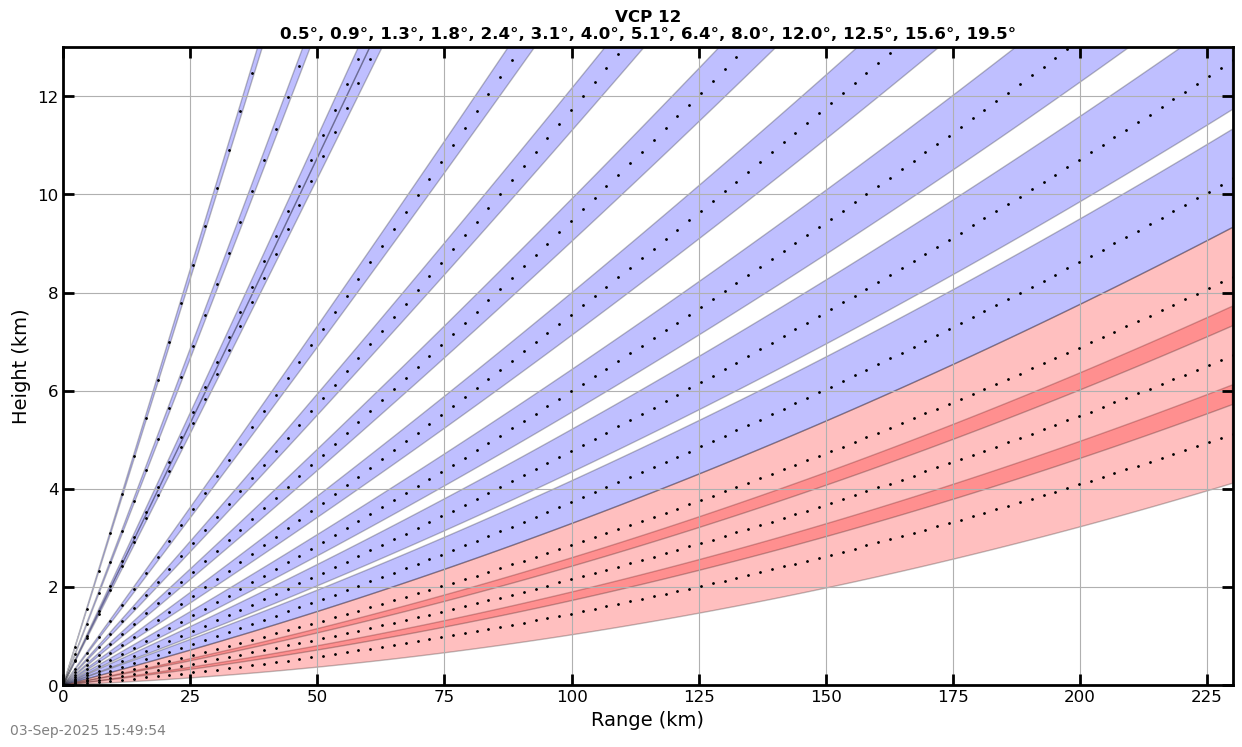

In [3]:
angles = [0.5, 0.9, 1.3, 1.8, 2.4, 3.1, 4.0, 5.1, 6.4, 8.0, 12.0, 12.5, 15.6, 19.50]
beamwidth = 0.50
radarbeam_slantrange_plot(angles, beamwidth,
    range_max=230, height_max=13, antenna_height=0,
    title_string='VCP 12',
    color_vector=['r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'])

# colors represent how often the angle is scanned
# b 1x
# r 2x 
# m 3x 
# g 4x

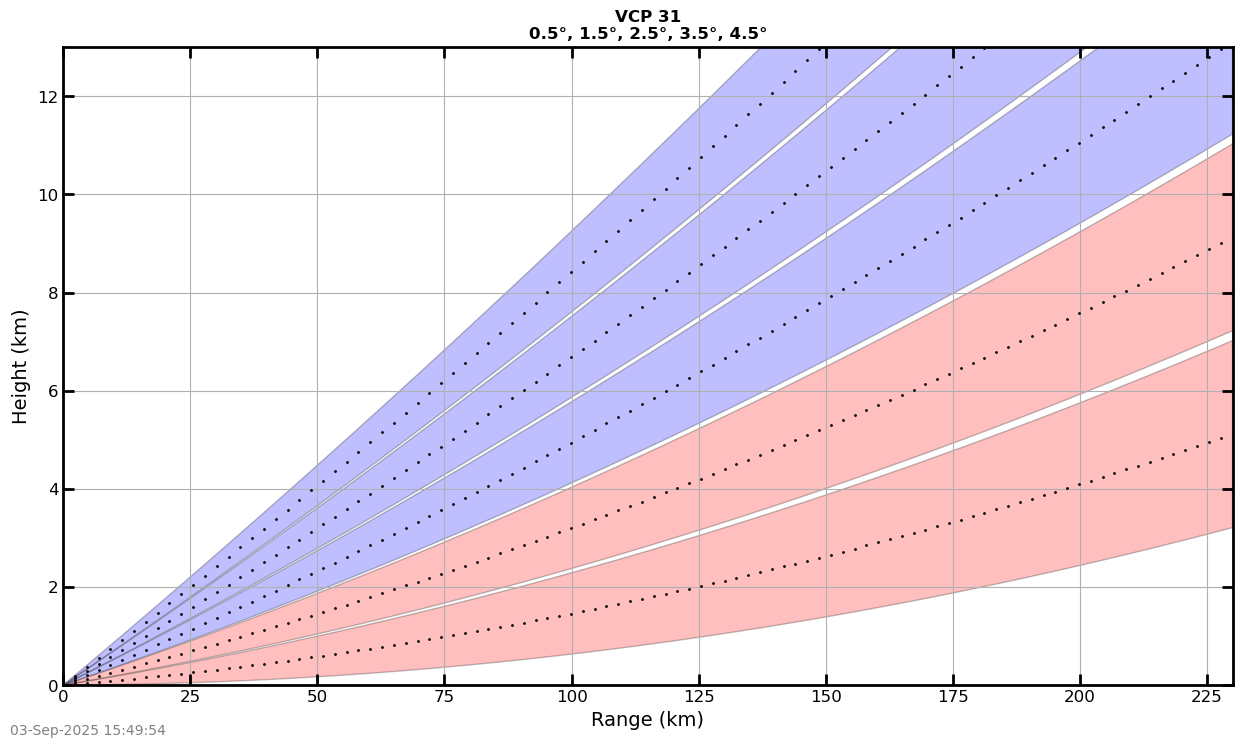

In [4]:
angles = [0.5, 1.5, 2.5, 3.5, 4.5]
beamwidth = 0.95
radarbeam_slantrange_plot(angles, beamwidth,
    range_max=230, height_max=13, antenna_height=0,
    title_string='VCP 31',
    color_vector=['r', 'r', 'b', 'b', 'b'])

# colors represent how often the angle is scanned
# b 1x
# r 2x 
# m 3x 
# g 4x

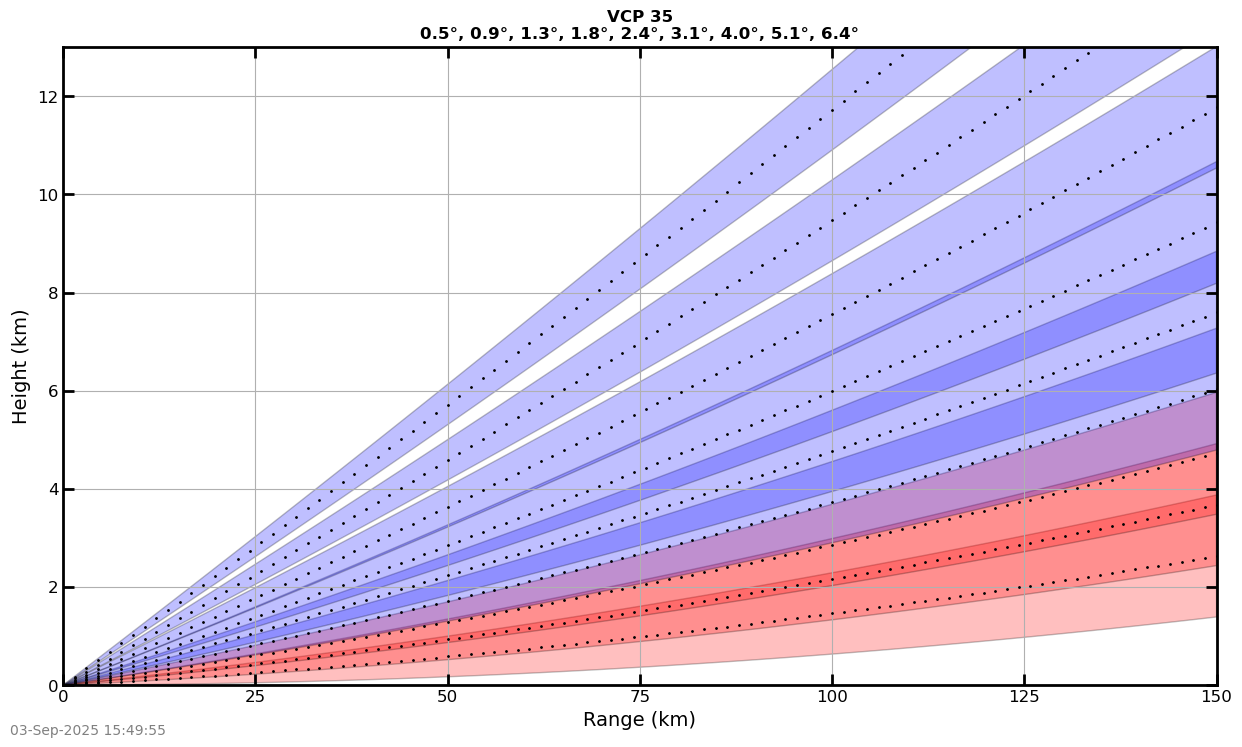

In [5]:
angles = [0.5, 0.9, 1.3, 1.8, 2.4, 3.1, 4, 5.1, 6.4]
beamwidth = 0.95
radarbeam_slantrange_plot(angles, beamwidth,
    range_max=150, height_max=13, antenna_height=0,
    title_string='VCP 35',
    color_vector=['r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b'])

# colors represent how often the angle is scanned
# b 1x
# r 2x 
# m 3x 
# g 4x

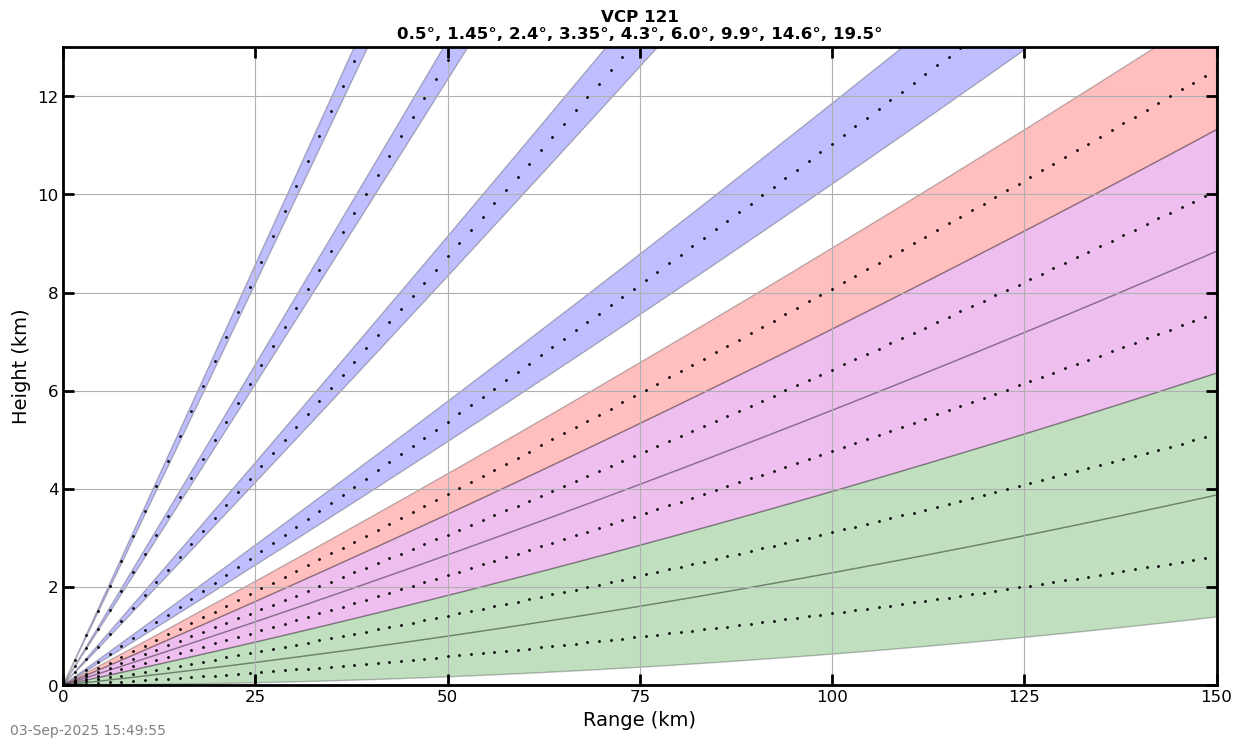

In [6]:
angles = [0.5, 1.45, 2.4, 3.35, 4.3, 6, 9.9, 14.6, 19.5]
beamwidth = 0.95
radarbeam_slantrange_plot(angles, beamwidth,
    range_max=150, height_max=13, antenna_height=0,
    title_string='VCP 121',
    color_vector=['g', 'g', 'm', 'm', 'r', 'b', 'b', 'b', 'b'])

# colors represent how often the angle is scanned
# b 1x
# r 2x 
# m 3x 
# g 4x

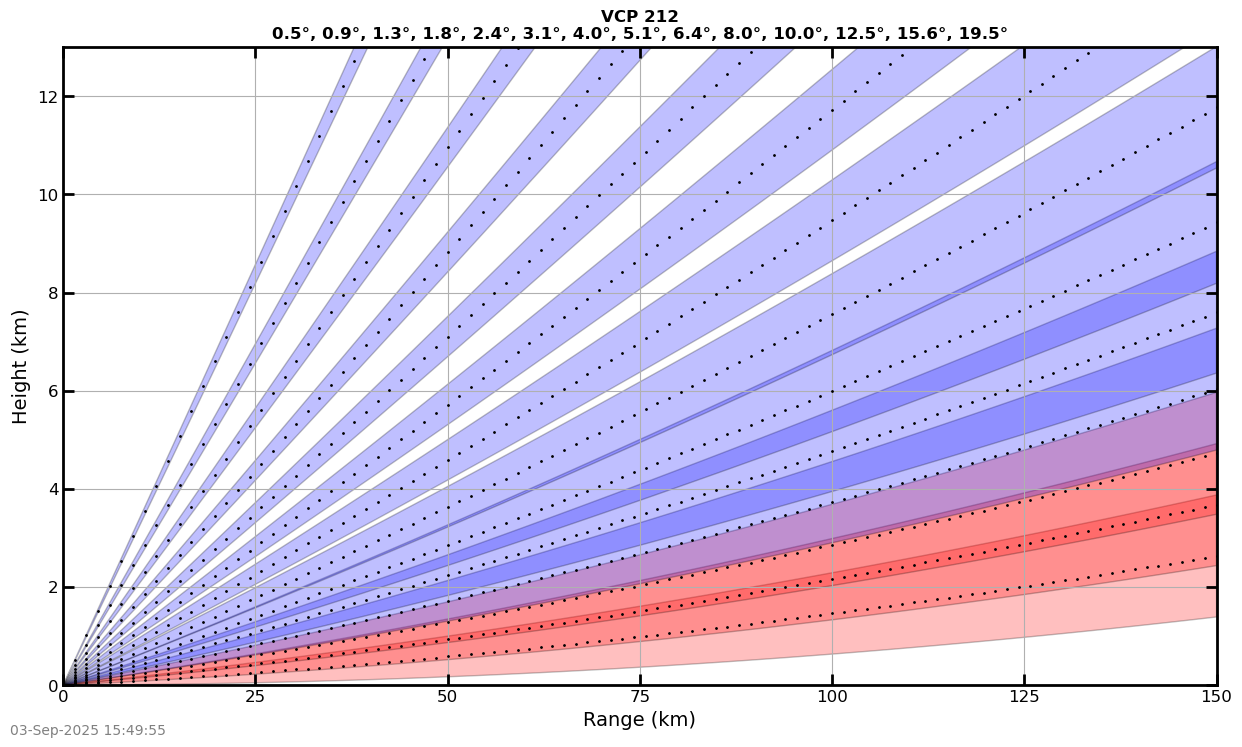

In [7]:
angles = [0.5, 0.9, 1.3, 1.8, 2.4, 3.1, 4.0, 5.1, 6.4, 8.0, 10.0, 12.5, 15.6, 19.5]
beamwidth = 0.95
radarbeam_slantrange_plot(angles, beamwidth,
    range_max=150, height_max=13, antenna_height=0,
    title_string='VCP 212',
    color_vector=['r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'])

# colors represent how often the angle is scanned
# b 1x
# r 2x 
# m 3x 
# g 4x

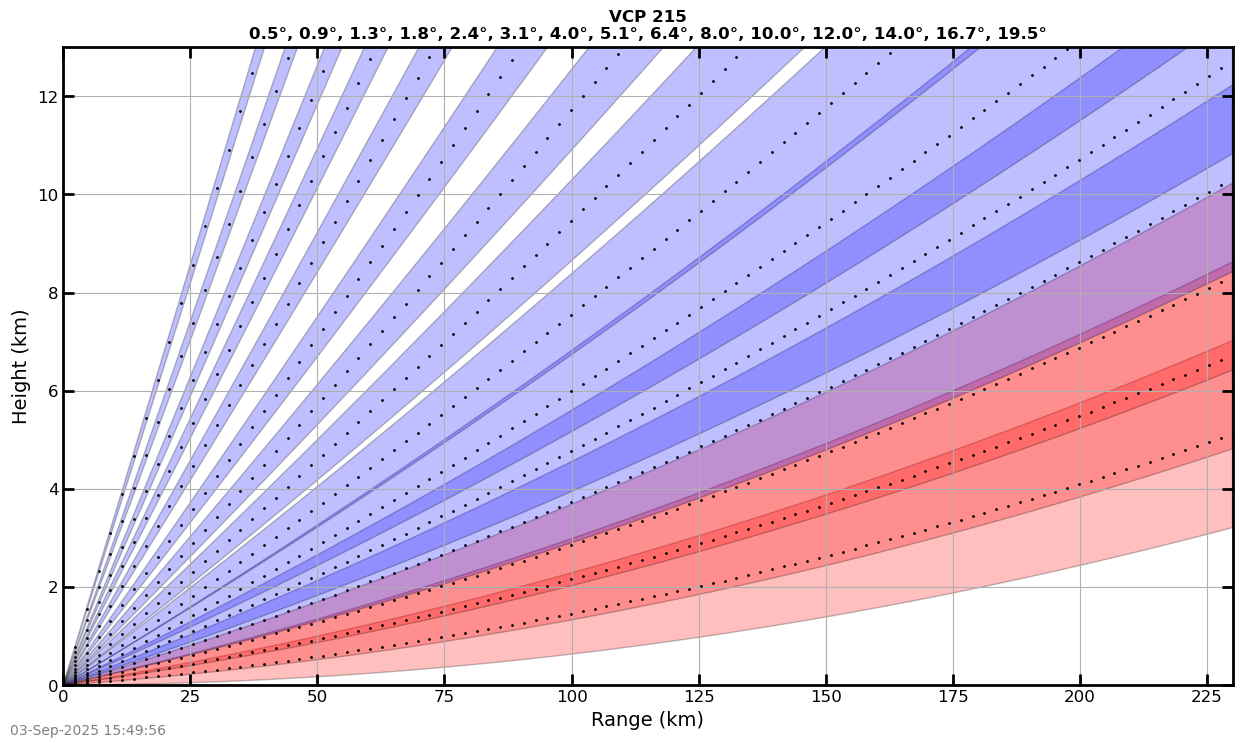

In [8]:
angles = [0.5, 0.9, 1.3, 1.8, 2.4, 3.1, 4.0, 5.1, 6.4, 8.0, 10.0, 12.0, 14.0, 16.7, 19.5]
beamwidth = 0.95
radarbeam_slantrange_plot(angles, beamwidth,
    range_max=230, height_max=13, antenna_height=0,
    title_string='VCP 215',
    color_vector=['r', 'r', 'r', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'])

# colors represent how often the angle is scanned
# b 1x
# r 2x 
# m 3x 
# g 4x